c:\Users\sewoo\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm

c:\Users\sewoo\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\llama\modeling_llama.py:655: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.



=== Generated ===
 15 cups of feed are given to the chickens in the morning.
15 cups of feed are given to the chickens in the afternoon.
15 + 25 = <<15+25=40>>40 cups of feed are given to the chickens in the morning and afternoon.
Wendi has 20 chickens, and she gives each chicken 3 cups of feed per day.
20 chickens * 3 cups of feed per chicken = 60 cups of feed per day.
Wendi has already given the chickens 40 cups of feed.
60 - 40 = <<60-40=20>>20 cups of feed are left for the final meal of the day.
#### 20

=== Hidden State Vector Shape ===
 (3072,)
Processing training data...
Collected 7473 training samples.
Processing test data...
Collected 1319 test samples.
Training feature shape: (7473, 3072)
Test feature shape: (1319, 3072)


c:\Users\sewoo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 73.24%


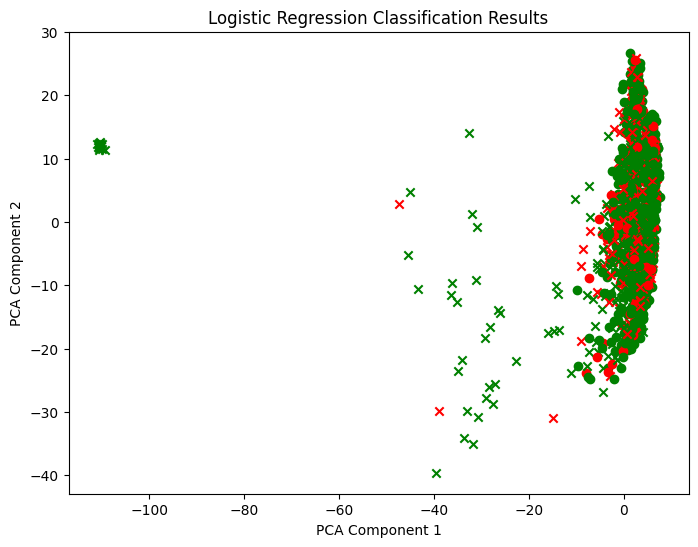

In [ ]:
import os
import torch
import transformers
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

HF_TOKEN = os.getenv("HF_TOKEN")

# model_name = "meta-llama/Llama-3.2-1B"
# model_name = "meta-llama/Llama-3.2-1B-Instruct"
# model_name = "meta-llama/Llama-3.2-3B"
model_name = "meta-llama/Llama-3.2-3B-Instruct"
# model_name = "google/gemma-2-2b"
# model_name = "google/gemma-2-2b-it"
# model_name = "google/gemma-2-9b"
# model_name = "google/gemma-2-9b-it"

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    token=HF_TOKEN,
    output_hidden_states=True,  # Enable hidden states
)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name,
    token=HF_TOKEN,
)

print(model, model.config)

from src.util.json_io import *

train_qnas = load_jsonlines(f'data/gsm8k/train.jsonl')
test_qnas = load_jsonlines(f'data/gsm8k/test.jsonl')
len(train_qnas), len(test_qnas)

import random; rseed = 42; random.seed(rseed)

nshot_prompt = f""
for i in random.sample(range(len(train_qnas)), 8):
    nshot_prompt += f"Question: {train_qnas[i]['question']}\nAnswer: {train_qnas[i]['answer']}\n\n"

print(nshot_prompt)

def question_to_prompt(question):
    return f"{nshot_prompt}Question: {question} Let's think step by step.\nAnswer: "

sample_i = 4
print(question_to_prompt(test_qnas[sample_i]['question']))

from src.util.gsm8k_helper import *
test_qnas[sample_i]['answer'], extract_num_from_ans(test_qnas[sample_i]['answer'])

def generate_answer(input_text):
    input_ids = tokenizer.encode(
        input_text, 
        return_tensors='pt', 
    ).to(model.device)

    with torch.no_grad():
        generated_outputs = model.generate(
            input_ids,
            max_length=input_ids.shape[1] + 512,
            do_sample=True, top_k=1,  # greedy decoding (deterministic)
            eos_token_id=tokenizer.encode(text='\n\n', add_special_tokens=False)[0],
            pad_token_id=tokenizer.eos_token_id,
            return_dict_in_generate=True,
            output_hidden_states=True,  # Return hidden states
        )

    generated_tokens = generated_outputs.sequences
    generated_text = tokenizer.decode(generated_tokens[0])

    # Get hidden states
    # generated_outputs.hidden_states is a tuple with length equal to the number of decoding steps
    # Each element is a tuple of (layers, batch_size, sequence_length, hidden_size)
    # We will get the hidden state from the last layer of the last token
    all_hidden_states = generated_outputs.hidden_states  # Tuple of (num_steps,) elements

    # Get the hidden states from the last step (corresponding to the last generated token)
    # Since we're using a causal LM, we can take the hidden state corresponding to the last token
    # in the last layer
    last_hidden_states = all_hidden_states[-1]  # Hidden states from the last decoding step
    # last_hidden_states is a tuple of layers
    # We'll take the last layer
    last_layer_hidden_state = last_hidden_states[-1]  # (batch_size, sequence_length, hidden_size)

    # Since batch_size=1 and sequence_length=1, we can extract the hidden state vector
    hidden_state_vector = last_layer_hidden_state[0, -1, :].cpu().numpy()  # Shape: (hidden_size,)

    # Process the generated text
    generated_answer = generated_text.split('Answer: ')[-1].split(tokenizer.special_tokens_map['eos_token'])[0].split('\n\n')[0]

    return generated_answer, hidden_state_vector

print('=== Input Text ===\n', question_to_prompt(test_qnas[sample_i]['question']))
print('\n=== Ground Truth ===\n', test_qnas[sample_i]['answer'])
generated_answer, hidden_state_vector = generate_answer(question_to_prompt(test_qnas[sample_i]['question']))
print('\n=== Generated ===\n', generated_answer)
print('\n=== Hidden State Vector Shape ===\n', hidden_state_vector.shape)

# %%
from datetime import datetime

current_time = datetime.now().strftime("%y%m%d_%H%M%S")
errors_log_path = f"log/errors-{model_name.replace('/', '-')}-{current_time}.txt"
with open(errors_log_path, 'w', encoding='utf-8') as log_file:
    log_file.write(f"{model}\n\n")
    log_file.write(f"{model.config}\n\n")
    log_file.write(f"[random seed]: {rseed}\n\n")
    log_file.write(f"[Nshot prompt]:\n{nshot_prompt}\n\n")
    log_file.write("=" * 40 + "\n\n")

# Collect features and labels from training data
train_features = []
train_labels = []

print("Processing training data...")
for i, qna in enumerate(train_qnas[:]):  # Limiting to 100 samples for demonstration
    input_text = question_to_prompt(qna['question'])
    generated_answer, hidden_state_vector = generate_answer(input_text)
    generated_answer_int = extract_num_from_ans(generated_answer)
    ground_truth_int = extract_num_from_ans(qna['answer'])

    label = int(generated_answer_int == ground_truth_int)
    train_features.append(hidden_state_vector)
    train_labels.append(label)

print(f"Collected {len(train_features)} training samples.")

# Collect features and labels from test data
test_features = []
test_labels = []

print("Processing test data...")
for i, qna in enumerate(test_qnas[:]):  # Limiting to 50 samples for demonstration
    input_text = question_to_prompt(qna['question'])
    generated_answer, hidden_state_vector = generate_answer(input_text)
    generated_answer_int = extract_num_from_ans(generated_answer)
    ground_truth_int = extract_num_from_ans(qna['answer'])

    label = int(generated_answer_int == ground_truth_int)
    test_features.append(hidden_state_vector)
    test_labels.append(label)

print(f"Collected {len(test_features)} test samples.")

# Convert lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

print("Training feature shape:", train_features.shape)
print("Test feature shape:", test_features.shape)

# Train logistic regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(train_features, train_labels)

# Evaluate on test data
test_predictions = clf.predict(test_features)
accuracy = np.mean(test_predictions == test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Visualize the results
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(test_features)

# Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(test_labels):
    if label == 1:
        marker = 'o'
    else:
        marker = 'x'
    color = 'green' if test_predictions[i] == test_labels[i] else 'red'  # Correct predictions in green
    plt.scatter(reduced_features[i, 0], reduced_features[i, 1], marker=marker, color=color)

plt.title('Logistic Regression Classification Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()
